In [1]:
import pickle
from astropy.table import Table
import astropy.coordinates as coord
import astropy.units as u
from gala.coordinates import reflex_correct

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import numpy as np
import scipy.stats


def getDust(G, bp, rp, ebv, maxnit=10):
    """ Compute the Gaia extinctions assuming relations from Babusieux
    Arguments: G, bp, rp, E(B-V)
    maxnit -- number of iterations
    Returns extinction in G,bp, rp
    Author: Sergey Koposov skoposov@cmu.edu
    """
    c1, c2, c3, c4, c5, c6, c7 = [0.9761, -0.1704,
                                  0.0086, 0.0011, -0.0438, 0.0013, 0.0099]
    d1, d2, d3, d4, d5, d6, d7 = [
        1.1517, -0.0871, -0.0333, 0.0173, -0.0230, 0.0006, 0.0043]
    e1, e2, e3, e4, e5, e6, e7 = [
        0.6104, -0.0170, -0.0026, -0.0017, -0.0078, 0.00005, 0.0006]
    A0 = 3.1*ebv
    P1 = np.poly1d([c1, c2, c3, c4][::-1])

    def F1(bprp): return np.poly1d(
        [c1, c2, c3, c4][::-1])(bprp)+c5*A0+c6*A0**2+c7*bprp*A0

    def F2(bprp): return np.poly1d(
        [d1, d2, d3, d4][::-1])(bprp)+d5*A0+d6*A0**2+d7*bprp*A0

    def F3(bprp): return np.poly1d(
        [e1, e2, e3, e4][::-1])(bprp)+e5*A0+e6*A0**2+e7*bprp*A0
    xind = np.isfinite(bp+rp+G)
    curbp = bp-rp
    for i in range(maxnit):
        AG = F1(curbp)*A0
        Abp = F2(curbp)*A0
        Arp = F3(curbp)*A0
        curbp1 = bp-rp-Abp+Arp

        delta = np.abs(curbp1-curbp)[xind]
        #print(scipy.stats.scoreatpercentile(delta[np.isfinite(delta)], 99))
        curbp = curbp1
    AG = F1(curbp)*A0
    Abp = F2(curbp)*A0
    Arp = F3(curbp)*A0
    return AG, Abp, Arp


In [4]:
def calc_distance(g, Ag):
    #Ag = 2.5*ebv
    gmag = g-Ag
    dist = 10.*10.**(0.2*(gmag-0.5))*1e-3
    return dist

In [5]:
with open('gaiaRRlyrae.pkl', 'rb') as f:
    d = Table(pickle.load(f))


In [6]:
d.keys()

['ra',
 'dec',
 'pmra',
 'pmdec',
 'parallax',
 'parallax_error',
 'int_average_g',
 'int_average_g_error',
 'g_absorption',
 'g_absorption_error',
 'pmra_error',
 'pmdec_error',
 'pmra_pmdec_corr',
 'ebv',
 'peak_to_peak_g',
 'num_clean_epochs_g',
 'astrometric_excess_noise',
 'phot_bp_mean_mag',
 'phot_rp_mean_mag',
 'g_transit_time',
 'g_transit_flux',
 'pf',
 'best_classification',
 'source_id']

In [7]:
Ag, Abp, Arp = getDust(d['int_average_g'], d['phot_bp_mean_mag'], d['phot_rp_mean_mag'], d['ebv'])

/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:680: RuntimeWarning: overflow encountered in multiply
  y = y * x + p[i]
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in multiply
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in multiply
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in multiply
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in add
/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:680: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


In [8]:
bprp = (d['phot_bp_mean_mag'] - Abp) - (d['phot_rp_mean_mag'] - Arp)
distances = calc_distance(d['int_average_g'], Ag)
c = coord.SkyCoord(ra=d['ra']*u.deg, 
                   dec=d['dec']*u.deg, 
                  distance=distances*u.kpc)

cGal = c.transform_to(coord.Galactocentric)

In [9]:
import astropy

In [10]:
astropy.__version__

'3.0.2'

In [11]:
good = ~np.isnan(d['pmra']) & ~np.isnan(d['pmdec']) & (d['ebv'] < 5) & (bprp < 1) & (Ag < 5) & (d['best_classification'] == 'RRab') & (np.abs(cGal.z) > 1*u.kpc)

/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [12]:
data = d[good]

In [13]:
Ag, Abp, Arp = getDust(data['int_average_g'], data['phot_bp_mean_mag'], data['phot_rp_mean_mag'], data['ebv'])

In [14]:
bprp = (data['phot_bp_mean_mag'] - Abp) - (data['phot_rp_mean_mag'] - Arp)

In [15]:
distances = calc_distance(data['int_average_g'], Ag)
c = coord.SkyCoord(ra=data['ra']*u.deg, 
                   dec=data['dec']*u.deg, 
                   pm_ra_cosdec=data['pmra']*u.mas/u.yr,
                   pm_dec=data['pmdec']*u.mas/u.yr,
                   distance = distances*u.kpc, 
                   radial_velocity=0.*u.km/u.s)
cCorrect = reflex_correct(c)
cGal = cCorrect.transform_to(coord.Galactic)

In [16]:
cGalactic = cCorrect.transform_to(coord.Galactic)

In [17]:
cGalTable = Table()
cGalTable['l'] = cGalactic.l
cGalTable['b'] = cGalactic.b
cGalTable['pm_l_cosb'] = cGalactic.pm_l_cosb
cGalTable['pm_b'] = cGalactic.pm_b
cGalTable['distance'] = distances




In [18]:
cGalTable.write('rrlyraeDynamics.txt', format='ascii')

In [19]:
vl = (cGalactic.pm_l_cosb*cGalactic.distance).to(u.km/u.s, equivalencies=u.dimensionless_angles())
vb = (cGalactic.pm_b*cGalactic.distance).to(u.km/u.s, equivalencies=u.dimensionless_angles())


In [20]:
cGal.set_representation_cls('cartesian')

In [21]:
c.shape

(79201,)

Text(0.5,1,'distances')

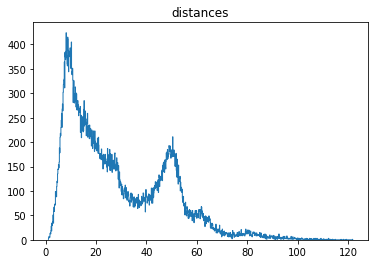

In [22]:
plt.hist(distances[~np.isnan(distances)], bins=1000, histtype='step')
plt.title('distances')

In [23]:
np.isnan(cGal.U).sum()
#for k in data.keys():
#    print(data[k][np.isnan(cGal.U)])
print(distances[np.isnan(cGal.U)], Ag[np.isnan(cGal.U)])

int_average_g
------------- ebv
---


In [24]:
locgalaxiesfile = '/Users/landerson/Dropbox (Simons Foundation)/data/Misc/NearbyGalaxies.dat'
locgaldata = Table.read(locgalaxiesfile, format='ascii')
gcfile = '/Users/landerson/Dropbox (Simons Foundation)/data/Misc/Harris-globclust.fits'
gcdata = Table.read(gcfile, format='fits')
locGalc = coord.SkyCoord(ra=locgaldata['RA'], dec=locgaldata['Dec'], unit=(u.hourangle, u.deg))
gcc     = coord.SkyCoord(ra=gcdata['ra'],     dec=gcdata['dec'], unit=(u.hourangle, u.deg))

locGalcGal = locGalc.transform_to(coord.Galactic)
gccGal = gcc.transform_to(coord.Galactic)

In [25]:
from sklearn.neighbors import KDTree as kdtree
import pandas as pd
import matplotlib as mpl

In [26]:
treedata = pd.DataFrame(data={'u':cGal.u/(1.*u.kpc), 
                              'v':cGal.v/(1.*u.kpc), 
                              'w':cGal.w/(1.*u.kpc),
                              'U':cGal.U/(10*u.km/u.s),
                              'V':cGal.V/(10*u.km/u.s), 
                              'W':cGal.W/(10*u.km/u.s)})

In [27]:
#treedataHigh = treedata.iloc[np.where(np.abs(cGalactic.b) >= 30.*u.deg)[0]]
#cGalacticHigh = cGalactic[np.abs(cGalactic.b) >= 30.*u.deg]

Text(0,0.5,'b')

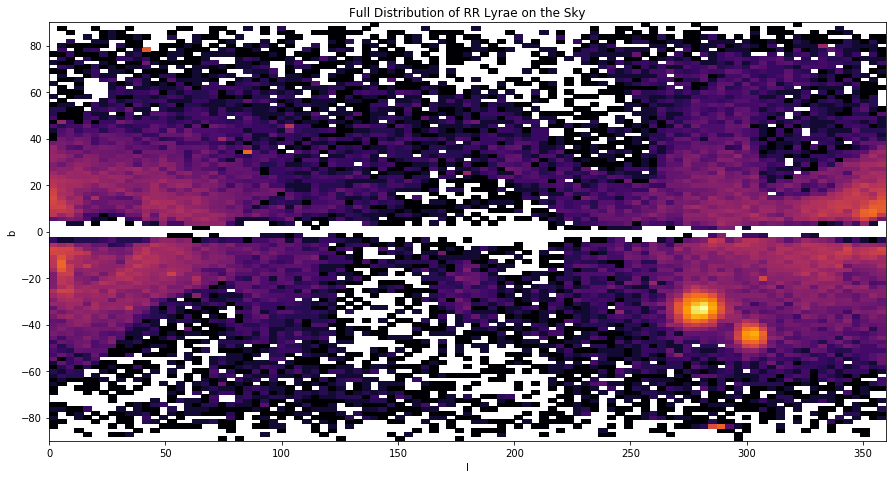

In [28]:
fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'aspect': 'equal'})
nbins = 100
xbins = np.linspace(0, 360, nbins)
ybins = np.linspace(-90, 90, nbins)

H, xe, ye = np.histogram2d(cGalactic.l, cGalactic.b, bins=(xbins, ybins))
im = ax.pcolormesh(xe, ye, H.T,
      cmap='inferno', norm=mpl.colors.LogNorm())#, vmax=20) #, vmin=-100, vmax=100)
ax.set_title('Full Distribution of RR Lyrae on the Sky')
ax.set_xlabel('l')
ax.set_ylabel('b')

In [29]:
tree = kdtree(treedata)

In [30]:
radius = 3.0


In [31]:
(ind, dist) = tree.query_radius(treedata, radius, count_only = False, return_distance = True)

In [32]:
maxMembers= 2
minMembers = 2
clumps = []
for i in ind:
    if (len(i)>=minMembers) & (len(i)<=maxMembers): 
        clumps.append(i)
print(len(clumps))

13377


In [36]:
for c in clumps:
    if len(c) > 2: print(len(c))

In [ ]:
#clumpTable = Table()
clumpTable = pd.DataFrame(columns = ('indices', 'ra', 'dec', 'pmra', 'pmdec', 'distance', 'width', 'angularSizeR', 'l', 'b'))
#figAll, axAll = plt.subplots()
figSky, axSky = plt.subplots(figsize=(15, 10))
colors=iter(plt.cm.rainbow(np.linspace(0,1,len(clumps))))
axSky.pcolormesh(xe, ye, H.T, cmap='Greys', norm=mpl.colors.LogNorm(), alpha=0.75)
ti = 0
distToKnown = 0. #deg
widthOfClump = 1 # kpc
maxSameAsBefore = 1
for j in range(len(clumps)):
    #check that it's small in physical space
    small = treedata.iloc[clumps[j]]
    width = np.max((small.u - np.mean(small.u))**2 + (small.v - np.mean(small.v))**2 + (small.w - np.mean(small.w))**2) #kpc
    if width < widthOfClump :
        #check that it isn't something already known 
        co = cGalactic[clumps[j]]
        dist_known = np.zeros(len(co) + len(co))
        for ii, (ll, bb) in enumerate(zip(co.l, co.b)):
            dist_known[ii] = np.min(np.sqrt((ll - locGalcGal.l)**2 + (bb - locGalcGal.b)**2).value)
            dist_known[ii + len(co)] = np.min(np.sqrt((ll - gccGal.l)**2 + (bb - gccGal.b)**2).value)
        #print(np.min(dist_known))
        if np.min(dist_known) > distToKnown: 
            #check that you haven't already plotted it 
            samesies = 0
            for k in range(j):
                same = np.in1d(clumps[j], clumps[k])
                #print(same, np.sum(same), j, k)
                samesies += np.sum(same)
            if (samesies < maxSameAsBefore+1):
                #color = next(colors)
                dnow= data[clumps[j]]
                clumpTable.loc[ti] = [clumps[j], dnow['ra'], dnow['dec'], dnow['pmra'], dnow['pmdec'], 
                                      distances[clumps[j]], width, np.max(width*u.kpc/cGalactic[clumps[j]].distance*180./np.pi), 
                                     np.median(cGalactic.l[clumps[j]]), np.median(cGalactic.b[clumps[j]])]
                ti += 1
                #print(samesies, clumps[j], dnow['ra'][0], dnow['dec'][0], width, np.max(width*u.kpc/cGalactic[clumps[j]].distance*180./np.pi))
                axSky.scatter(cGalactic.l[clumps[j]], cGalactic.b[clumps[j]], s=len(clumps[j])*2)#, c=color)
axSky.scatter(locGalcGal.l, locGalcGal.b, s=40, facecolor='none', edgecolor='black', label='local galaxies')
axSky.scatter(gccGal.l, gccGal.b, s=40, facecolor='none', edgecolor='red', label='globular clusters')
axSky.set_xlabel('l')
axSky.set_ylabel('b')
axSky.set_xlim(0, 360)
axSky.set_ylim(-90, 90)
axSky.legend(fontsize=15)
figSky.savefig('allsky_pairs.png')
#plt.close(fig)

In [49]:
print(np.sqrt(np.var(clumpTable.iloc[0]['pmra']))*4, np.sqrt(np.var(clumpTable.iloc[0]['pmdec']))*4)

0.43601420197892393 0.5457976043613754


In [57]:
from os import path
import sqlutilpy as sqlutil
def queryDatabase(query, columns, post_query, cache_file='db.pickle', queryPro=None):

    #cache_file = "reducedPM2.pickle"

    if not path.exists(cache_file):
        if queryPro is not None:
            res = sqlutil.get(queryPro,
                          db='wsdb', host='cappc127.ast.cam.ac.uk', 
                          user='gaia_sprint', password='NOT@Gaia_sprint', 
                          asDict=True)
        else:
            res = sqlutil.get(query.format(','.join(columns), post_query),
                          db='wsdb', host='cappc127.ast.cam.ac.uk', 
                          user='gaia_sprint', password='NOT@Gaia_sprint', 
                          asDict=True)

        with open(cache_file, "wb") as f:
            pickle.dump(res, f)
        
    else:
        with open(cache_file, "rb") as f:
            res = pickle.load(f)
    return res

/anaconda3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [51]:
dataCMD = Table.read('/Users/landerson/Downloads/MIST_iso_5b18346c0ece6.iso.cmd', format='ascii.commented_header', header_start=12)

In [52]:
dataCMD.keys()

['EEP',
 'isochrone_age_yr',
 'initial_mass',
 'star_mass',
 'log_Teff',
 'log_g',
 'log_L',
 '[Fe/H]_init',
 '[Fe/H]',
 'Bessell_U',
 'Bessell_B',
 'Bessell_V',
 'Bessell_R',
 'Bessell_I',
 '2MASS_J',
 '2MASS_H',
 '2MASS_Ks',
 'Kepler_Kp',
 'Kepler_D51',
 'Hipparcos_Hp',
 'Tycho_B',
 'Tycho_V',
 'Gaia_G_DR2Rev',
 'Gaia_BP_DR2Rev',
 'Gaia_RP_DR2Rev',
 'TESS',
 'phase']

In [53]:
dataCMD['phase'].max()

6.0

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


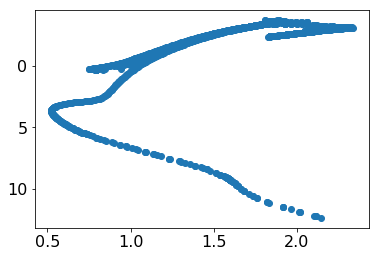

In [54]:
good = (dataCMD['phase'] <6) & (dataCMD['phase'] > -1)
plt.scatter(dataCMD['Gaia_BP_DR2Rev'][good] - dataCMD['Gaia_RP_DR2Rev'][good], dataCMD['Gaia_G_DR2Rev'][good])
plt.gca().invert_yaxis()

In [40]:
clumpSky = coord.SkyCoord(ra=clumpTable['ra']*u.deg, dec=clumpTable['dec']*u.deg, distance=clumpTable['distance']*u.kpc)

In [41]:
clumpGal= clumpSky.transform_to(coord.Galactocentric)

In [42]:
r = np.sqrt(clumpGal.x.value**2 + clumpGal.y.value**2 + clumpGal.z.value**2)

(1, 204.12808513598492)

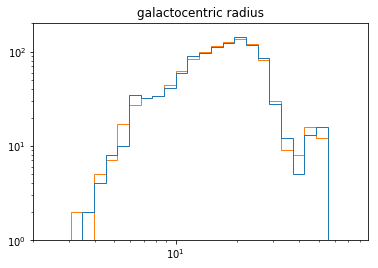

In [53]:
plt.hist(r, bins=np.logspace(-1, 1.8, 50), histtype='step', log=True)
plt.title('galactocentric radius')
plt.xscale('log')
plt.xlim(2, )
plt.ylim(1,)

In [38]:
clumpTable

,indices,ra,dec,pmra,pmdec,distance,width,angularSizeR,l,b
0,"[25, 85]","[51.0919848795914, 54.2025094214856]","[12.9641790175713, 13.3865943867852]","[1.1424228433379, 1.17484950470088]","[-0.802993364370808, -0.95791606057296]","[28.67532040593799, 28.441644007126033]",0.594297,1.1972124972650775,171d47m12.2508s,-34d10m58.1682s
1,"[72, 53]","[57.4215997554074, 56.9683506411744]","[13.5964703065623, 12.1062016319622]","[0.184482553105745, 0.201513688904933]","[-1.93024423068589, -1.96227887093498]","[36.84942458748121, 35.798348128993034]",0.518900,0.8305074900164408,175d48m03.7116s,-31d16m42.9941s
2,"[110, 13313]","[62.6748049748966, 55.574547967942]","[17.0176873537929, 8.06515139525639]","[3.52440802737007, 3.72698849922082]","[-4.15996144027421, -4.29986301727427]","[9.13898182890184, 8.434322146001792]",0.873470,5.9336274259310455,177d32m46.6344s,-30d07m41.2124s
3,"[129, 254]","[64.9984974005223, 66.2887405647685]","[20.1703332371687, 20.9591534965474]","[4.01181390442106, 4.68727317273204]","[-3.71622512389699, -4.70518794704258]","[9.154930378267265, 7.4259359034680985]",0.758131,5.849462634672895,175d29m31.4579s,-20d06m34.1461s
4,"[167, 182]","[57.0826413273196, 60.5336287730537]","[20.3354133341051, 25.7167264753109]","[9.52872048680877, 7.24452654940585]","[-11.6387642297787, -8.92206709536881]","[3.5882344485212068, 4.4048481903336585]",0.213652,3.4115223130567562,168d51m59.9045s,-23d02m22.026s
5,"[2224, 347]","[91.6772833849494, 88.340672040661]","[49.4892220699353, 43.1866519479043]","[1.24636392028473, 1.1147418453991]","[-1.23575189842331, -1.48114782374201]","[6.316493859891238, 6.988162002470521]",0.263897,2.393762733984664,166d11m13.8677s,11d04m42.4863s
6,"[353, 2219]","[87.2587617273483, 90.0451821222074]","[45.9847372998696, 47.9874448729357]","[3.44763544417281, 3.39873374289806]","[-4.51951500833972, -4.8964872811364]","[9.015985193107305, 9.202187987356941]",0.056816,0.3610626271952655,165d12m04.1931s,10d36m51.3424s
7,"[445, 2275]","[75.8830302406706, 97.2466029257173]","[56.3719846066202, 55.8772639050003]","[3.12192143841182, 1.34828443919663]","[-5.31016766575222, -5.78819841951308]","[8.740283797939032, 9.200105083238352]",0.912606,5.982470084487909,156d02m20.1159s,14d05m00.9777s
8,"[2284, 447]","[104.54289793837, 80.553912722226]","[61.7048017912797, 59.927729403471]","[2.13898173492333, 5.07984877323976]","[-12.4032130486269, -9.23300775404066]","[5.056120382319199, 5.738754015775836]",0.421127,4.772194770773135,152d49m16.2198s,18d44m10.8027s
9,"[448, 449]","[81.9134843537547, 83.1231471433527]","[59.6390402789381, 60.1188454901072]","[1.74943070202939, 1.4730671320548]","[-2.53055297637534, -2.85762874361987]","[17.826326820729257, 17.12066409383056]",0.138404,0.46318251305617325,151d54m56.011s,13d50m09.0838s


In [ ]:
clumpT

In [ ]:
len(clumpTable)

In [ ]:
plt.hist(clumpTable['angularSizeR'].value, bins=100)

In [81]:
mpl.rc('font',**{'family':'sans-serif', 'serif':['Computer Modern Serif'], 
             'sans-serif':['Helvetica'], 'size':16, 
             'weight':500, 'variant':'normal'}) 
goodcmd = (dataCMD['phase'] <6) & (dataCMD['phase'] > -1)
minAngularDistance = 1.0 #deg
minSigPM = 0.5 #mas/yr
cmd_bprp = dataCMD['Gaia_BP_DR2Rev'][goodcmd] - dataCMD['Gaia_RP_DR2Rev'][goodcmd]
cmd_MG = dataCMD['Gaia_G_DR2Rev'][goodcmd]
index_order = np.argsort(clumpTable['angularSizeR'].values)
#print(index_order[1])
minr = np.min(clumpTable['angularSizeR'])
print('distance, pmra, pmdec, pmraWidth, pmdecWidth, ra, dec, angular distance')
for ii, i in enumerate(range(len(index_order[0:300]))):
    i = index_order[i]
    nstars = len(clumpTable.loc[i]['ra'])
    ra = clumpTable.loc[i]['ra'][0]
    dec = clumpTable.loc[i]['dec'][0]
    pmra = clumpTable.loc[i]['pmra'][0]
    pmdec = clumpTable.loc[i]['pmdec'][0]
    angular_distance = np.max((clumpTable.loc[i]['angularSizeR'], minAngularDistance))
    distance = clumpTable.loc[i]['distance'][0]
    #print(ra, dec, pmra, pmdec, angular_distance, distance)

    pm2Max = pmra**2 + pmdec**2
    pmramed = np.median(clumpTable.loc[i]['pmra'])
    pmdecmed = np.median(clumpTable.loc[i]['pmdec'])
    pmrasig = np.max((np.sqrt(np.var(clumpTable.iloc[i]['pmra']))*4, minSigPM))
    pmdecsig = np.max((np.sqrt(np.var(clumpTable.iloc[i]['pmdec']))*4, minSigPM))
    maxParallax = 10./distance
    print(distance, pmramed, pmdecmed, pmrasig, pmdecsig, angular_distance)

    
    queryPro = """WITH x AS (SELECT  * FROM gaia_dr2.gaia_source AS gs WHERE q3c_radial_query(gs.ra, gs.dec, {0}, {1}, {2}))
    SELECT x.ra, x.dec, x.pmra, x.pmdec, phot_g_mean_mag, ebv, phot_bp_mean_mag, phot_rp_mean_mag
        FROM x
            WHERE parallax < {3} AND abs(pmra - {4:0.6f}) < {5:0.6f} AND abs(pmdec - {6:0.6f}) < {7:0.6f};""".format(ra, dec, 
                                                                                                                         angular_distance, 
                                                                                                                         maxParallax, 
                                                                                                                         pmramed, pmrasig,
                                                                                                                         pmdecmed, pmdecsig)
    

    #columns = ['parallax', 'int_average_g', 'ebv', 'phot_bp_mean_mag', 'phot_rp_mean_mag']
    #query = """select {0} from gaia_dr2.gaia_source as gs, gaia_DR2.vari_rrlyrae as rr {1}"""
    #cuts = "WHERE ".format(ra, dec, angular_distance)
    query = ""
    columns = ""
    cuts = ""
    res = queryDatabase(query, columns, cuts, cache_file='rrlyrae_pairs_{0}.pkl'.format(ii), queryPro=queryPro)


    dnow = Table(res)
    Ag, Abp, Arp = getDust(dnow['phot_g_mean_mag'], dnow['phot_bp_mean_mag'], dnow['phot_rp_mean_mag'], dnow['ebv'])
    bprp = (dnow['phot_bp_mean_mag'] - Abp) - (dnow['phot_rp_mean_mag'] - Arp)

    MG = dnow['phot_g_mean_mag'] - Ag - 5.*np.log10(distance*1e3/10)


    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    if len(dnow) > 2000:
        xbins = np.linspace(0, 2.5, 50)
        ybins = np.linspace(-6, 10, 200)
        HH, xx, yy = np.histogram2d(bprp, MG, bins=(xbins, ybins))
        im = ax[0].pcolormesh(xx, yy, HH.T,
          cmap='inferno', norm=mpl.colors.LogNorm())
        ybins = np.linspace(10, 20, 200)
        HH, xx, yy = np.histogram2d(bprp, dnow['phot_g_mean_mag'] - Ag, bins=(xbins, ybins))
        im = ax[1].pcolormesh(xx, yy, HH.T,
          cmap='inferno', norm=mpl.colors.LogNorm())
        ax[1].invert_yaxis()
        ax[1].set_ylim(20, 10)
    else:
        if len(dnow) < 100:
            size = 20
        else:
            size = 3
        ax[0].scatter(bprp, MG, s=size)
        ax[1].scatter(bprp, dnow['phot_g_mean_mag'] - Ag, s=size)
        for axis in [ax[0], ax[1]]:
            axis.set_xlim(0, 2.5)
        ax[0].set_ylim(10, -6)
        ax[1].set_ylim(20, 10)
    ax[0].scatter(cmd_bprp, cmd_MG, s=3, alpha=0.1)
    ax[1].scatter(cmd_bprp, cmd_MG + 5.*np.log10(distance*1e3/10), s=3, alpha=0.1)
    ax[0].set_xlabel('bp - rp')
    ax[0].set_ylabel('M_G')
    ax[0].set_title('{0:0.2f} kpc'.format(distance))
    ax[1].set_xlabel('bp - rp')
    ax[1].set_ylabel('G')
    ax[1].set_title('{0} RRlyrae'.format(nstars))

    ax[2].pcolormesh(xe, ye, H.T, cmap='Greys', norm=mpl.colors.LogNorm(), alpha=0.75)
    ax[2].scatter(clumpTable.loc[i]['l'], clumpTable.loc[i]['b'], s=100)
    ax[2].scatter(locGalcGal.l, locGalcGal.b, s=40, facecolor='none', edgecolor='black', label='local galaxies', alpha=0.5, zorder=np.inf)
    ax[2].scatter(gccGal.l, gccGal.b, s=40, facecolor='none', edgecolor='red', label='globular clusters', alpha=0.5, zorder=np.inf)
    ax[2].set_xlabel('l')
    ax[2].set_ylabel('b')
    ax[2].set_xlim(0, 360)
    ax[2].set_ylim(-90, 90)
    vtannow = np.sqrt(pmra**2 + pmdec**2)*4.*distance
    ax[2].set_title('{0:0.2f} km/s'.format(vtannow))
    plt.tight_layout()
    fig.savefig('cmd_rrlyrae_pairs_{0:02d}.png'.format(ii))
    plt.close(fig)

    #plt.gca().invert_yaxis()

distance, pmra, pmdec, pmraWidth, pmdecWidth, ra, dec, angular distance
43.8687136008293 2.3375223223736548 -0.330515339444237 0.5 0.5 1.0


/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


47.77873616410354 1.69839140791103 -0.15506936414913 0.5 0.5 1.0
20.00762432021124 0.0908997222503452 -1.293438210489105 0.5 0.5 1.0
4.6536610910007115 -2.41591460250388 -7.77197584140493 1.8724814417783602 0.5 1.0
15.6328084470087 -1.0290010401980065 -2.9911943582511302 0.585301888222814 0.5 1.0
6.416602361164147 0.6185049204929365 -9.514913252584726 0.551035768417046 0.6500349475088605 1.0
20.629922621343244 0.3635145129692985 -2.680497992545895 0.5 0.5 1.0
24.632867483410774 -0.63332577921072 -0.5766614352387149 0.5 0.5 1.0
16.923612988671444 0.429839049876431 -2.61878797534505 0.5328819444019921 0.5 1.0
23.963782242815157 0.044738907891269206 -2.22020640188487 0.5 0.5 1.0
10.743408144544738 -0.06799763240469801 2.12681001042683 0.976735044909268 0.5 1.0
23.736546294497195 -0.792007739683263 -2.7753950294229552 0.5 0.5 1.0
20.177423707444664 -1.194833800707665 -1.13164006994853 0.5 0.5 1.0
25.054184609597353 0.427438292140998 -2.27642031849101 0.5 0.5 1.0
51.302260852314944 1.429839

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[7402 7360 7414 7062 7351 7586 7434 7405 7662 7561]
[9593 9745 9850 9060 9563 9541 9538 9560 9069 9544]
[9971 9848 9825 9759 9223 9961 9297 9912 9216 9250]
[22758 22885 22880 22245 22319 22519 22902 22327 22335 22842]
[54988 57700 53728 55066 57893 57696 57881 57689 55108 57658]
[55875 56120 56212 56254 55675 55851 56136 56112 56144 56192]


(-90, 90)

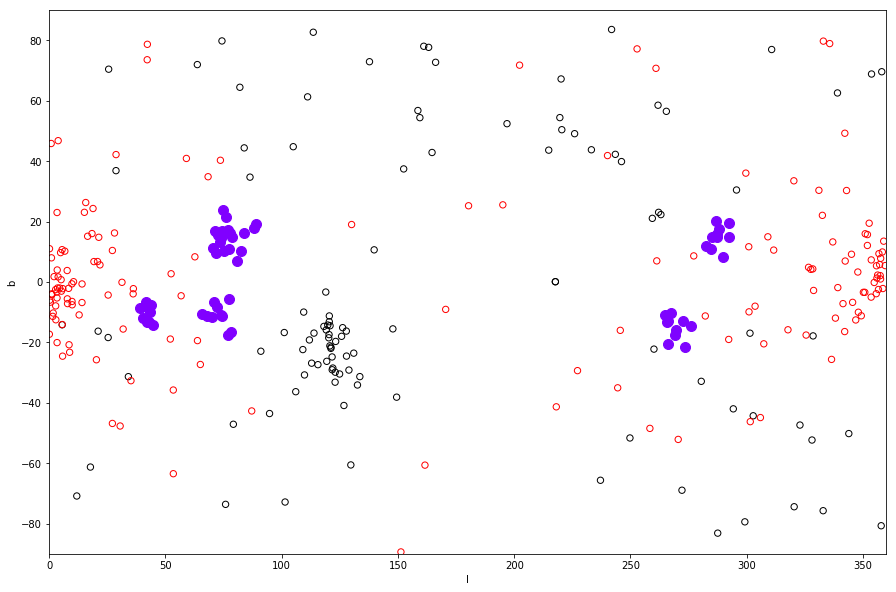

In [33]:
#figAll, axAll = plt.subplots()
figSky, axSky = plt.subplots(figsize=(15, 10))
colors=iter(plt.cm.rainbow(np.linspace(0,1,len(clumps))))
mpl.rc('font',**{'family':'sans-serif', 'serif':['Computer Modern Serif'], 
             'sans-serif':['Helvetica'], 'size':16, 
             'weight':500, 'variant':'normal'}) 
for j, ci in enumerate(clumps):
    samesies = 0
    for k in range(j):
        same = np.in1d(clumps[j], clumps[k])
        samesies += np.sum(same)
    #if clumps[j] != clumps[j-1]
    if samesies < 1:
        small = treedata.iloc[clumps[j]]
        co = cGalactic[clumps[j]]
        vll = vl[clumps[j]]
        vbb = vb[clumps[j]]
        dist_known_gal = np.zeros(len(co))
        dist_known_gcc = np.zeros(len(co))
        for ii, (ll, bb) in enumerate(zip(co.l, co.b)):
            dist_known_gal[ii] = np.min(np.sqrt((ll - locGalcGal.l)**2 + (bb - locGalcGal.b)**2).value)
            dist_known_gcc[ii] = np.min(np.sqrt((ll - gccGal.l)**2 + (bb - gccGal.b)**2).value)
        dist_known = np.concatenate((dist_known_gal, dist_known_gcc))
        if np.min(dist_known) < 5: 
            continue
        fig, ax = plt.subplots(ncols=4, figsize=(20, 5))
        xx = [co.l, co.b, co.l]
        yy = [co.b, co.distance, co.distance]
        vxx = [vll, vbb, vll]
        vyy = [vbb, np.zeros(len(vbb)), np.zeros(len(vll))]
        #xx = [small.u, small.v, small.w]
        #yy = [small.v, small.w, small.u]
        #vxx = [small.U, small.V, small.W]
        #vyy = [small.V, small.W, small.U]
        lxx = ['l', 'b', 'l']
        lyy = ['b', 'd', 'd']
        color = next(colors)
        for i, (x, y, vx, vy, lx, ly) in enumerate(zip(xx, yy, vxx, vyy, lxx, lyy)):
            ax[i].quiver(x, y, vx, vy, color=color)
            ax[i].set_xlabel(lx)
            ax[i].set_ylabel(ly)
            #axAll.quiver(x, y, vx, vy)
        ax[3].pcolormesh(xe, ye, H.T, cmap='Greys', norm=mpl.colors.LogNorm(), alpha=0.75)
        ax[3].scatter(co.l, co.b, s=40, c=color)
        ax[3].scatter(locGalcGal.l, locGalcGal.b, s=40, facecolor='none', edgecolor='black', label='local galaxies')
        ax[3].scatter(gccGal.l, gccGal.b, s=40, facecolor='none', edgecolor='red', label='globular clusters')
        ax[3].set_xlabel('l')
        ax[3].set_ylabel('b')
        ax[3].set_xlim(0, 360)
        ax[3].set_ylim(-90, 90)
        #ax[3].legend(fontsize=15)
        plt.tight_layout()
        fig.savefig('rrLyrae_kdtree_{0:03d}.png'.format(j))
        plt.close(fig)
        axSky.scatter(cGalactic.l[clumps[j]], cGalactic.b[clumps[j]], s=len(clumps[j])*10, c=color)
        print(clumps[j])
axSky.scatter(locGalcGal.l, locGalcGal.b, s=40, facecolor='none', edgecolor='black')
axSky.scatter(gccGal.l, gccGal.b, s=40, facecolor='none', edgecolor='red')
axSky.set_xlabel('l')
axSky.set_ylabel('b')
axSky.set_xlim(0, 360)
axSky.set_ylim(-90, 90)
#plt.close(fig)